<a href="https://colab.research.google.com/github/JohnWu777/Colab-python-class/blob/main/MA_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設置

In [16]:
# 輸入pandas＝pd (pandas是python的資料分析程式庫)
import pandas as pd
# 輸入numpy=np (numpy是python的函數庫)
import numpy as np
# 讀取CSV文件，取名manova_data_raw
manova_data_raw = pd.read_csv("HW1-data.csv")

In [17]:
#選擇要分析的特定行（colums）[ethnic,gender,reading_3,math_3]
manova_data = manova_data_raw.iloc[:,[2,3,11,12]].copy()
#刪除ethnic的空格
manova_data['ethnic'] = manova_data['ethnic'].str.strip()
#確認資料結類型
print(manova_data.dtypes)

ethnic       object
gender        int64
reading_3     int64
math_3        int64
dtype: object


In [18]:
#轉換ethnic和gender數據類型為category
manova_data['ethnic'] = manova_data['ethnic'].astype('category')
manova_data['gender'] = manova_data['gender'].astype('category')
#0替換為女,1替換為男
manova_data['gender'] = manova_data['gender'].replace({0:'female',1:'male'})
#確認資料結類型
print(manova_data.dtypes)

ethnic       category
gender       category
reading_3       int64
math_3          int64
dtype: object


<ipython-input-18-ed56294b8a3d>:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  manova_data['gender'] = manova_data['gender'].replace({0:'female',1:'male'})


In [19]:
# 安裝 pingouin套件
%pip install pingouin
# 輸入pingouin＝pg
import pingouin as pg

# 檢驗共變異矩陣（Box'M test）

In [20]:
# gender 做Box'M test (檢驗性別組間[男v.s.女]共變異數矩陣是否相等)
box_m_test_g = pg.box_m(manova_data, dvs=['reading_3','math_3'],group='gender',alpha=0.0001)
print(box_m_test_g)
# ethnic 做Box'M test (檢驗性別組間[不同種族]共變異數矩陣是否相等)
box_m_test_e = pg.box_m(manova_data, dvs=['reading_3','math_3'],group='ethnic',alpha=0.0001)
print(box_m_test_e)

         Chi2   df      pval  equal_cov
box  4.069624  3.0  0.254043       True
          Chi2   df      pval  equal_cov
box  16.935469  6.0  0.009523       True


equal_cov=True（各變異數的共變異數矩陣相等）
P value > a(=0.0001)，不拒絕H0，不存在差異

# 檢驗多元常態分佈（Henze-Zirkler test）

In [21]:
# 多元常態分佈檢驗（使用Henze-Zirkler test）
from pingouin import multivariate_normality as mn
# 拆分性別資料集（男、女）
FIX_G = manova_data.groupby('gender')
female_data = FIX_G.get_group('female')
male_data = FIX_G.get_group('male')
# （男、女）多元常態分佈檢驗
female_mntest = mn(female_data[['reading_3','math_3']],alpha=0.5)
male_mntest = mn(male_data[['reading_3','math_3']],alpha=0.5)
print(female_mntest)
print(male_mntest)

HZResults(hz=52.03983616528838, pval=5.0138039859526384e-39, normal=False)
HZResults(hz=62.270144994981386, pval=8.954408458776431e-43, normal=False)


<ipython-input-21-455e0e348849>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  FIX_G = manova_data.groupby('gender')


normal=False 不符合多元常態



# MANOVA

In [22]:
# 輸入statsmodels套件裡的MANOVA功能
from statsmodels.multivariate.manova import MANOVA
# 建立MANOV方程式
formula = 'reading_3+math_3~ethnic * gender'
# 執行MANOVA
manova_model = MANOVA.from_formula(formula,data=manova_data)
manova_results = manova_model.mv_test()
# 輸出MANOVA結果
print(manova_results)

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value   Num DF  Den DF   F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda   0.0017 2.0000 186.0000 56089.7107 0.0000
         Pillai's trace   0.9983 2.0000 186.0000 56089.7107 0.0000
 Hotelling-Lawley trace 603.1152 2.0000 186.0000 56089.7107 0.0000
    Roy's greatest root 603.1152 2.0000 186.0000 56089.7107 0.0000
------------------------------------------------------------------
                                                                  
-------------------------------------------------------------------
          ethnic          Value   Num DF   Den DF   F Value  Pr > F
-------------------------------------------------------------------
           Wilks' lambda  0.9288  4.0000  372.0000   3.5012  0.0080
          Pi

根據結果可以看出ethnic具有顯著差異（看Wilks' lambda=0.92,p<0.01）
因此繼續做post-hoc

# 畫圖 mean plot

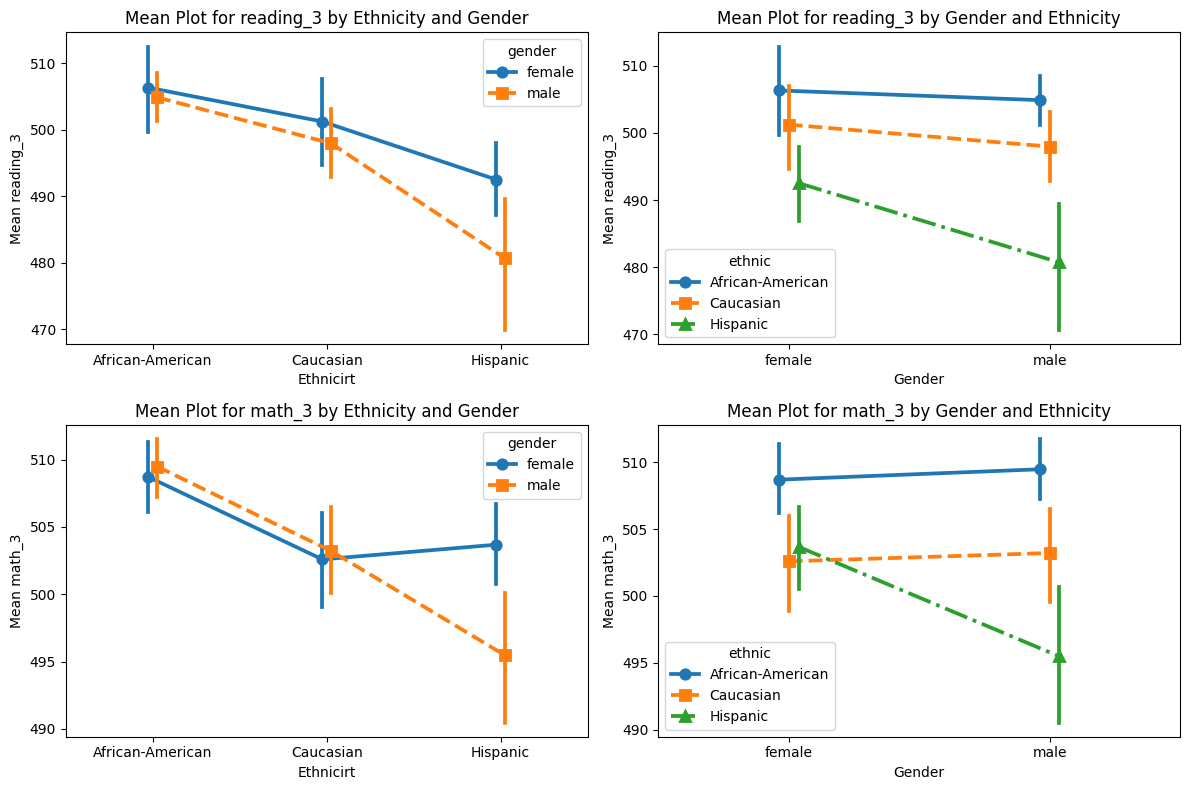

In [23]:
# 輸入seaborn繪圖套件
import seaborn as sns
# 輸入matplotlib繪圖套件
import matplotlib.pyplot as plt
#畫出群組平均值和置信區間
##確定圖片大小
plt.figure(figsize=(12,8))
#按照「種族」和「性別」劃分reading_3
  ##確定圖片在象限上的位置
plt.subplot(2,2,1)
  ##圖片參數設定
sns.pointplot(x='ethnic',y='reading_3',hue='gender',data=manova_data,dodge=True, errorbar=('ci',95),markers=['o','s'],linestyles=['-','--'])
  ##圖片titl,x,y軸取名
plt.title('Mean Plot for reading_3 by Ethnicity and Gender')
plt.xlabel('Ethnicirt')
plt.ylabel('Mean reading_3')
#按照「性別」和「種族」劃分reading_3
  ##確定圖片在象限上的位置
plt.subplot(2,2,2)
  ##圖片參數設定
sns.pointplot(x='gender',y='reading_3',hue='ethnic',data=manova_data,dodge=True, errorbar=('ci',95),markers=['o','s','^'],linestyles=['-','--','-.'])
  ##圖片titl,x,y軸取名
plt.title('Mean Plot for reading_3 by Gender and Ethnicity')
plt.xlabel('Gender')
plt.ylabel('Mean reading_3')
#按照「種族」和「性別」劃分math_3
  ##確定圖片在象限上的位置
plt.subplot(2,2,3)
  ##圖片參數設定
sns.pointplot(x='ethnic',y='math_3',hue='gender',data=manova_data,dodge=True, errorbar=('ci',95),markers=['o','s'],linestyles=['-','--'])
  ##圖片titl,x,y軸取名
plt.title('Mean Plot for math_3 by Ethnicity and Gender')
plt.xlabel('Ethnicirt')
plt.ylabel('Mean math_3')
#按照「性別」和「種族」劃分math_3
  ##確定圖片在象限上的位置
plt.subplot(2,2,4)
  ##圖片參數設定
sns.pointplot(x='gender',y='math_3',hue='ethnic',data=manova_data,dodge=True, errorbar=('ci',95),markers=['o','s','^'],linestyles=['-','--','-.'])
  ##圖片titl,x,y軸取名
plt.title('Mean Plot for math_3 by Gender and Ethnicity')
plt.xlabel('Gender')
plt.ylabel('Mean math_3')
#自動調整佈局
plt.tight_layout()
#輸出結果
plt.show()

從右圖可以看出種族（ethnic）有統計上的顯著差異。因此要做post-hoc。另外因有兩個自變項需要先分別對reading_2和math_2做two-way anova

但在做ANOVA之前，需要做同質性檢驗（levene test）

# (levent test + Two-way ANOVA)：reading_3

In [24]:
#使用pingouin.homoscedasticity做 levene test
levene_test_ethnic = pg.homoscedasticity(data=manova_data,dv='reading_3',group='ethnic')
print(levene_test_ethnic)
levene_test_gender = pg.homoscedasticity(data=manova_data,dv='reading_3',group='gender')
print(levene_test_gender)

# Two-way ANOVA
aov = pg.anova(dv='reading_3',between=['ethnic','gender'],data=manova_data,detailed=True)
  ##小數點至第三位
aov.round(3)

               W      pval  equal_var
levene  0.579737  0.561033       True
               W      pval  equal_var
levene  0.000164  0.989805       True


,Source,SS,DF,MS,F,p-unc,np2
0,ethnic,10824.308,2.0,5412.154,17.583,0.000,0.158
1,gender,891.994,1.0,891.994,2.898,0.090,0.015
2,ethnic * gender,781.206,2.0,390.603,1.269,0.284,0.013
3,Residual,57559.618,187.0,307.805,NaN,NaN,NaN


*   reading_3的levene test結果：equal_var=True（P value>0.05,不拒絕H0假設，組間有同質性）
*    reading_3的Two-way ANOVA結果：性別和種族的交互效果不顯著（ethnic * gender）的p value>0.05，因此不用繼續做ANOVA（性別對 reading_3的影響，種族對 reading_3的影響）

#(levent test + Two-way ANOVA)：math_3

In [25]:
#使用pingouin.homoscedasticity做 levene test
levene_test_ethnic = pg.homoscedasticity(data=manova_data,dv='math_3',group='ethnic')
print(levene_test_ethnic)
levene_test_gender = pg.homoscedasticity(data=manova_data,dv='math_3',group='gender')
print(levene_test_gender)

# Two-way ANOVA
aov = pg.anova(dv='math_3',between=['ethnic','gender'],data=manova_data,detailed=True)
  ##小數點至第三位
aov.round(3)

               W      pval  equal_var
levene  1.305336  0.273501       True
               W      pval  equal_var
levene  1.911683  0.168391       True


,Source,SS,DF,MS,F,p-unc,np2
0,ethnic,3220.867,2.0,1610.433,18.463,0.000,0.165
1,gender,72.082,1.0,72.082,0.826,0.364,0.004
2,ethnic * gender,647.797,2.0,323.898,3.713,0.026,0.038
3,Residual,16311.093,187.0,87.225,NaN,NaN,NaN


*   math_3的levene test結果：equal_var=True（P value>0.05,不拒絕H0假設，組間有同質性）
*   math_3的Two-way ANOVA結果：性別和種族的交互效果顯著（ethnic * gender）的p value<0.05，因此繼續做ANOVA（性別對math_3的影響，種族對math_3的影響）
***殘差（Residual）為組內均方（MSW）＝87.225**

# Simple main effect test(ANOVA)：math_3（性別與不同種族是否有顯著關係）
固定性別（gender），並檢查種族(ethnic)之間的差異
，針對不同的性別進行迴圈ANOVA

In [26]:
for gender_level in manova_data['gender'].unique():
  subset_data = manova_data[manova_data['gender'] == gender_level]
# 輸入pingouin套件裡的ANOVA功能
  submodel = pg.anova(dv='math_3',between='ethnic',data=subset_data,detailed=True)
  print(f"Simple Main Effect Test for ethnic within gender Level {gender_level}")
  print(submodel.round(3))
#輸出空行（僅為了美觀）
  print("\n")

Simple Main Effect Test for ethnic within gender Level female
   Source       SS  DF       MS      F  p-unc    np2
0  ethnic   724.27   2  362.135  4.507  0.014  0.095
1  Within  6909.64  86   80.345    NaN    NaN    NaN


Simple Main Effect Test for ethnic within gender Level male
   Source        SS   DF        MS      F  p-unc    np2
0  ethnic  3144.393    2  1572.197  16.89    0.0  0.251
1  Within  9401.453  101    93.084    NaN    NaN    NaN




組間均方（MSB）：
*   女性MSB＝362.135
*   男性MSB＝1572.197




# 計算F值
F value = MSB/MSW
*   F-female=362.135/87.225=4.15
*   F-male=1572.197/87.225=18.02

# 計算P值
已知
*   殘差（Residual）DF=dfd分母自由度=187
*   ethnic DF=dfn分子自由度=2

In [27]:
#從SciPy庫中導入F分布的相關功能
from scipy.stats import f
#計算p-value=f.sf(F_value, dfn,dfd)
#女性p值
p_value_female = f.sf(4.15,2,187)
print("female P-value:", p_value_female)
#男性p值
p_value_male = f.sf(18.02,2,187)
print("male P-value:", p_value_male)

female P-value: 0.01723973015515351
male P-value: 6.972724178820868e-08


# Post-hoc test (Scheffe test)
由於P值具有統計上顯著：P value<0.05，需要做事後檢驗Post-hoc test，選擇使用Scheffe test

In [28]:
#安裝scikit-posthocs
%pip install scikit-posthocs
import scikit_posthocs as sp

In [29]:
# female
female_data = manova_data[manova_data['gender'] == 'female'][["ethnic","math_3"]]
scheffe_female = sp.posthoc_scheffe(female_data,group_col='ethnic',val_col='math_3')
print("scheffe on math_3 for different ethnic within female sample")
print(scheffe_female)
print("\n")
# male
male_data = manova_data[manova_data['gender'] == 'male'][["ethnic","math_3"]]
scheffe_male = sp.posthoc_scheffe(male_data,group_col='ethnic',val_col='math_3')
print("scheffe on math_3 for different ethnic within male sample")
print(scheffe_male)
print("\n")

scheffe on math_3 for different ethnic within female sample
                  African-American  Hispanic  Caucasian
African-American          1.000000  0.142739   0.020949
Hispanic                  0.142739  1.000000   0.915642
Caucasian                 0.020949  0.915642   1.000000


scheffe on math_3 for different ethnic within male sample
                  African-American      Hispanic  Caucasian
African-American      1.000000e+00  6.269838e-07   0.019603
Hispanic              6.269838e-07  1.000000e+00   0.016036
Caucasian             1.960326e-02  1.603616e-02   1.000000




/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_posthocs.py:2092: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_grouped = x.groupby(_group_col)[_val_col]
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_posthocs.py:2092: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_grouped = x.groupby(_group_col)[_val_col]


從Scheffe test結果配合上圖發現：


*   當性別為女性時，只有數學分數顯示出African-American與Caucasian之間的差異（0.020949）。女性中African-American的數學平均分數比Caucasian高 (見上圖4)。而Hispanic和African-American沒有統計上的差異(0.142739)，Hispanic和Caucasian沒有統計上的差異(0.915642)
*   當性別為男性時，三個種族的數學分數皆有統計差異(見上圖3)： African-American高於Caucasian和Hispanic，而Caucasian則高於Hispanic。可以推論，在數學分數方面，African-American > Caucasian > Hispanic。
